In [6]:
import pandas as pd

In [7]:
import networkx as nx   #그래프 기반 네트워크 분석 
import osmnx as ox      # 공간데이터 네트워크 분석 
from IPython.display import IFrame
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
ox.config(log_console=True)
ox.__version__

'1.2.2'

In [8]:
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
from descartes import PolygonPatch  #수정한 부분 - 주석 해제
#import shapefile

In [13]:
#import matplotlib as mpl
import matplotlib.pyplot as plt
#import seaborn as sns
plt.rc('font', family='Malgun Gothic') #한글 폰트 적용시
plt.rcParams["figure.figsize"] = (10,10) #차트 기본 사이즈

# OSMNX (Open Street Map + NetworkX ?)를 이용한 네트워크 분석  

### 개발자 블로그   
https://geoffboeing.com/2016/11/osmnx-python-street-networks/

소스코드  
https://github.com/gboeing/osmnx  
https://pypi.org/project/osmnx/  

### 구현 예제   
https://github.com/gboeing/osmnx-examples/tree/master/notebooks

### 참조 사이트   
https://networkx.org/documentation/stable//index.html

## OSM 경로 데이터 로딩 

### 1. 지명

c:\Users\thlee\AppData\Local\Programs\Python\Python39\lib\site-packages\osmnx\utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(
c:\Users\thlee\AppData\Local\Programs\Python\Python39\lib\site-packages\osmnx\io.py:107: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)
c:\Users\thlee\AppData\Local\Programs\Python\Python39\lib\site-packages\geopandas\plotting.py:482: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.draw()


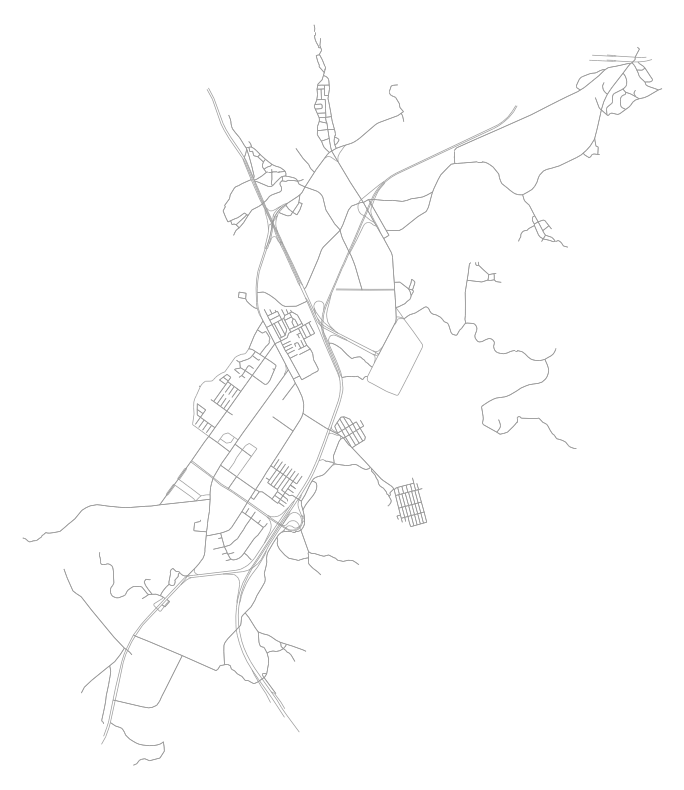

In [30]:
ox.config(log_console=True, use_cache=True)

# get a graph for some city
G = ox.graph_from_place('과천시, 경기도, 대한민국', network_type='drive', simplify=False) #,  buffer_dist=200) 

# /data/파일명 폴더 내의 edges/ nodes폴더에 링크와 노트 shp파일이 저장됨
ox.save_graph_shapefile(G, filepath='./data/osm_road')

fig, ax = ox.plot_graph(G, figsize=(10,10), node_size=0, edge_linewidth=0.5, bgcolor='w')

Network type (network_type)

‘drive’ : get drivable public streets (but not service roads)  
‘drive_service’ : get drivable public streets, including service roads  
‘walk’ : get all streets and paths that pedestrians can use (this network type ignores one-way directionality)  
‘bike’ : get all streets and paths that cyclists can use  
‘all’ : download all (non-private) OSM streets and paths  
‘all_private’ : download all OSM streets and paths, including private-access ones  

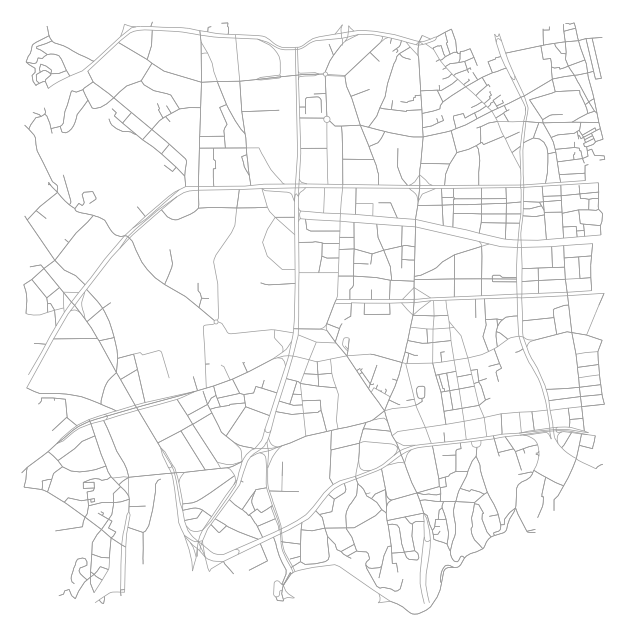

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [36]:
G = ox.graph_from_point((37.5655, 126.9779), dist=1200, network_type='drive_service')  #좌표 반경 범위 
ox.plot_graph(G, node_size=0, edge_linewidth=0.5, bgcolor='w')

OSM 데이터 대상 설정 방법   
- a bounding box  
- a lat-long point plus a distance   
- an address plus a distance   
- a polygon of the desired street network’s boundaries   
- a place name or list of place names   

## 최단경로 분석 

서소문~광화문

In [18]:
orig_node = ox.nearest_nodes(G, 126.97322081586789, 37.557638657147585) #서울역 연세세브란스빌딩 앞 
dest_node = ox.nearest_nodes(G, 126.98542855257266, 37.57442565618067)  #인사동 쌈지길 

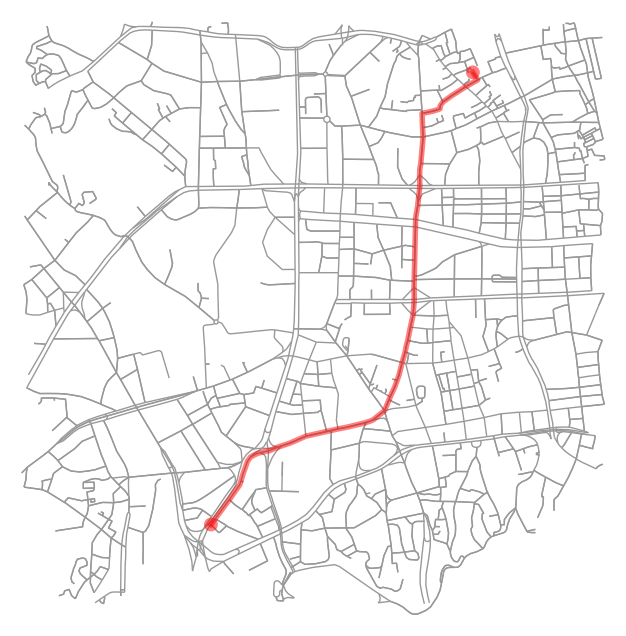

In [19]:
# find the route between these nodes then plot it
route = nx.shortest_path(G, orig_node, dest_node, weight='length')
fig, ax = ox.plot_graph_route(G, route, node_size=0, bgcolor='w' ) #, figsize=(10,10)

## 시간거리 분석

OSMnx에서 지원하는 시간거리 기능

In [20]:
# impute missing edge speeds then calculate edge travel times
G = ox.add_edge_speeds(G)
# speed_kph 항목을 만들고 maxspeed 값을 부여. maxspeed가 없는 레코드는 highway(도로 종류)별 평균값을 부여 
G = ox.add_edge_travel_times(G)
# travel_time 항목을 만들고 legth / speed_kph 값을 부여 

In [21]:
# you can convert your graph to node and edge GeoPandas GeoDataFrames
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_edges.head(3)

osmid  oneway lanes  ref    name      highway  \
u         v          key                                                      
287631232 1936511583 0    919985574    True     4    6    새문안로      primary   
          2930525587 0    180793307   False   NaN  NaN    새문안로  residential   
          287712330  0    919985573   False   NaN  NaN  새문안로3길  residential   

                         maxspeed reversed   length  speed_kph  travel_time  \
u         v          key                                                      
287631232 1936511583 0         60    False  168.025       60.0         10.1   
          2930525587 0        NaN     True   73.923       43.8          6.1   
          287712330  0        NaN    False   15.334       43.8          1.3   

                                                                   geometry  \
u         v          key                                                      
287631232 1936511583 0    LINESTRING (126.97255 37.57005, 126.97446 37.5...   
          2930525587 0    LINESTRING (126.97255 37.57005, 126.97257 37.5...   
          287712330  0    LINESTRING (126.97255 37.57005, 126.97255 37.5...   

                         junction bridge tunnel access service  
u         v          key                                        
287631232 1936511583 0        NaN    NaN    NaN    NaN     NaN  
          2930525587 0        NaN    NaN    NaN    NaN     NaN  
          287712330  0        NaN    NaN    NaN    NaN     NaN

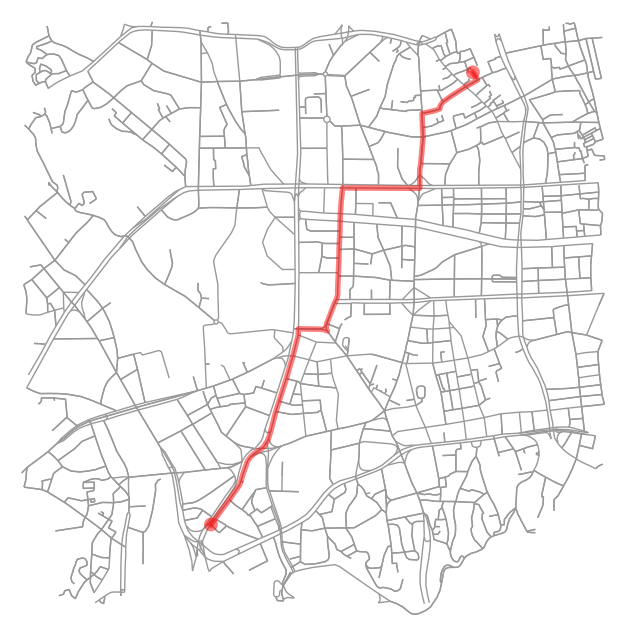

In [22]:
# find the shortest path between these nodes, minimizing travel time, then plot it
route = ox.shortest_path(G, orig_node, dest_node, weight='travel_time')
fig, ax = ox.plot_graph_route(G, route, node_size=0, bgcolor='w')

In [23]:
filepath = './result/route_map01.html'
route_graph_map = ox.plot_route_folium(G, route, popup_attribute='name', weight=3, color='Red')
route_graph_map.save(filepath)
IFrame(filepath, width=950, height=500)

## 도로 등급별 속도 및 소요시간 적용한 시간거리 분석

OSM 경로 데이터의 타입별로 기준 속도를 부여하고, 이 기준속도와 도형 길이를 가지고 소요시간을 산출하여 최적경로(시간거리)를 구해보자 

In [24]:
hwy_speeds = {"mortorway" : 80, "primary" : 55, "secondary": 50, "tertiary": 60, 
              "residential": 20, "living_street": 20, "service": 20, "unclassified": 10, "road": 10}
G = ox.add_edge_speeds(G, hwy_speeds)
G = ox.add_edge_travel_times(G)

In [25]:
# you can convert your graph to node and edge GeoPandas GeoDataFrames
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_edges.head(3)

osmid  oneway lanes  ref    name      highway  \
u         v          key                                                      
287631232 1936511583 0    919985574    True     4    6    새문안로      primary   
          2930525587 0    180793307   False   NaN  NaN    새문안로  residential   
          287712330  0    919985573   False   NaN  NaN  새문안로3길  residential   

                         maxspeed reversed   length  speed_kph  travel_time  \
u         v          key                                                      
287631232 1936511583 0         60    False  168.025       60.0         10.1   
          2930525587 0        NaN     True   73.923       20.0         13.3   
          287712330  0        NaN    False   15.334       20.0          2.8   

                                                                   geometry  \
u         v          key                                                      
287631232 1936511583 0    LINESTRING (126.97255 37.57005, 126.97446 37.5...   
          2930525587 0    LINESTRING (126.97255 37.57005, 126.97257 37.5...   
          287712330  0    LINESTRING (126.97255 37.57005, 126.97255 37.5...   

                         junction bridge tunnel access service  
u         v          key                                        
287631232 1936511583 0        NaN    NaN    NaN    NaN     NaN  
          2930525587 0        NaN    NaN    NaN    NaN     NaN  
          287712330  0        NaN    NaN    NaN    NaN     NaN

https://networkx.org/documentation/networkx-1.10/reference/classes.multidigraph.html

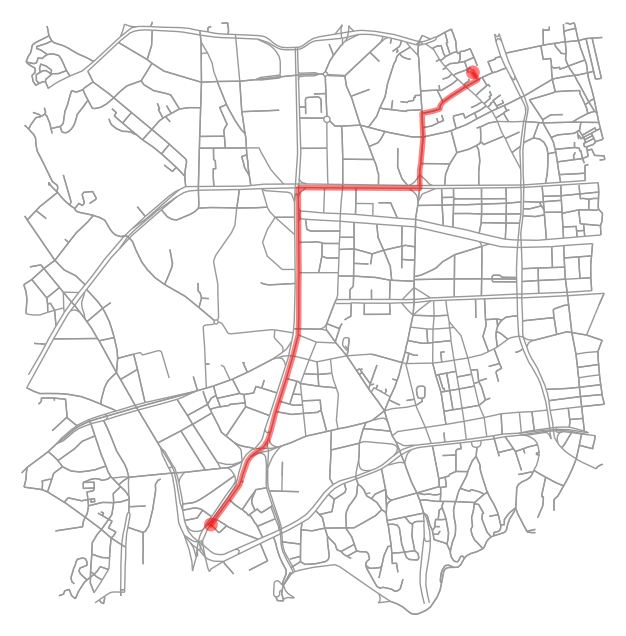

In [26]:
# find the shortest path between these nodes, minimizing travel time, then plot it
route = ox.shortest_path(G, orig_node, dest_node, weight='travel_time')
fig, ax = ox.plot_graph_route(G, route, node_size=0, bgcolor='w')

## 서비스 영역 분석

In [37]:
center_node = ox.nearest_nodes(G, 126.9779, 37.5655)  #서울광장 좌표
trip_times = [5, 10, 15]  # 이동 시간 범위
travel_speed = 4.5         #속도

In [38]:
meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute
for _, _, _, data in G.edges(data=True, keys=True):
    data["time"] = data["length"] / meters_per_minute

In [33]:
# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=3, cmap="RdPu", start=0, return_hex=True)

### Matplotlib Colormap
https://matplotlib.org/stable/tutorials/colors/colormaps.html

In [39]:
# make the isochrone polygons 
isochrone_polys1 = []

for trip_time in sorted(trip_times, reverse=True):
    subgraph1 = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    node_points1 = [Point((data['x'], data['y'])) for node, data in subgraph1.nodes(data=True)]
    bounding_poly1 = gpd.GeoSeries(node_points1).unary_union.convex_hull
    isochrone_polys1.append(bounding_poly1)

c:\Users\thlee\AppData\Local\Programs\Python\Python39\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


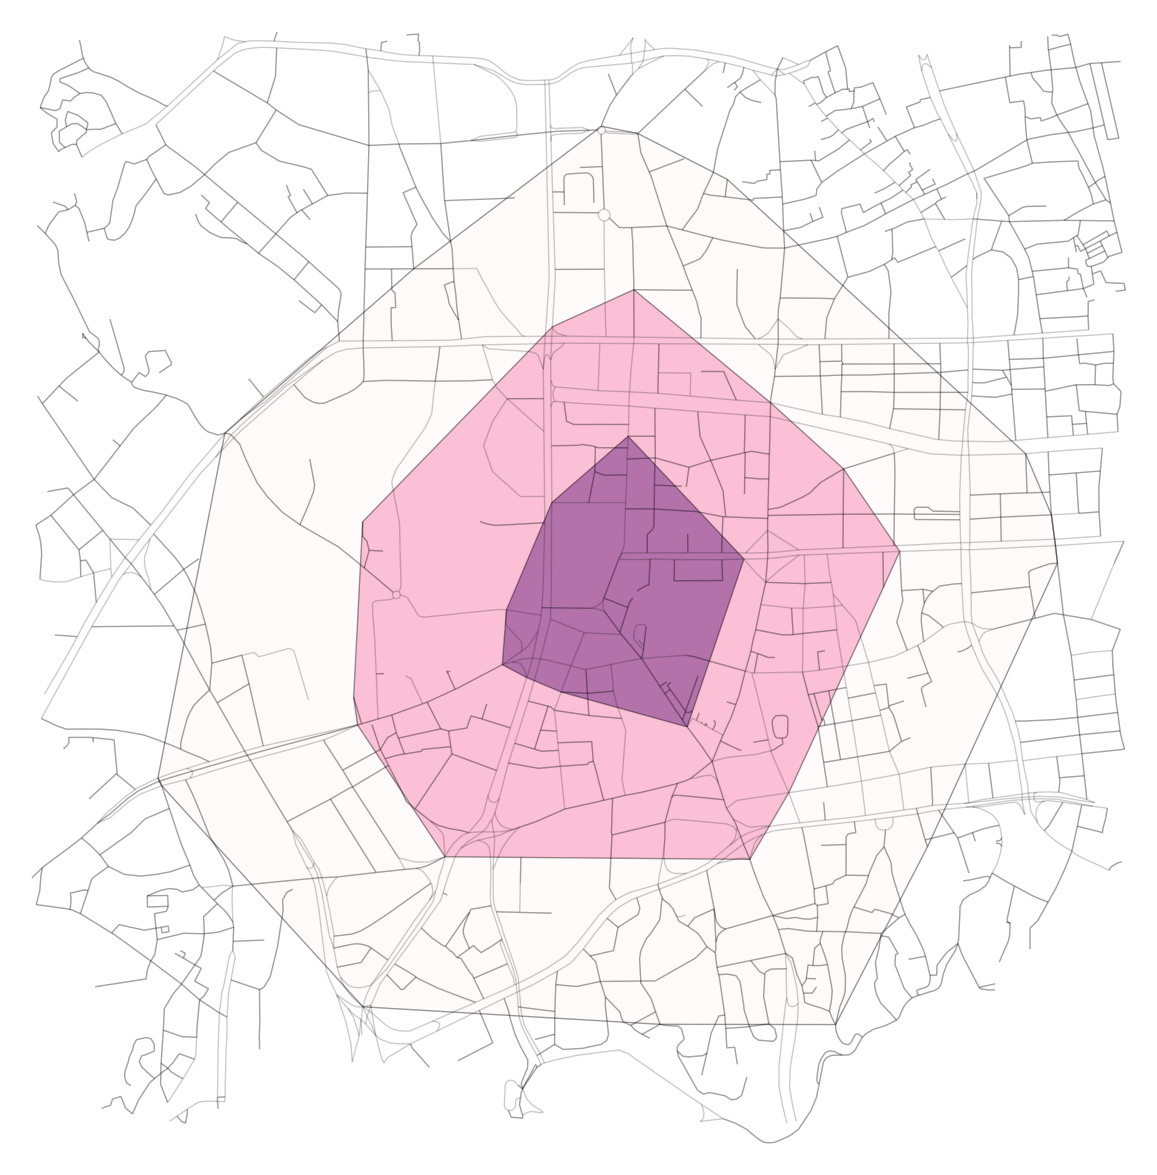

In [40]:
# plot the network then add isochrones as colored descartes polygon patches
fig, ax = ox.plot_graph(G, figsize=(15,15), edge_color='k', edge_alpha=0.2, node_color='none', bgcolor='white', show=False, close=False)

for polygon1, fc in zip(isochrone_polys1,iso_colors):  
    patch1 = PolygonPatch(polygon1, alpha=0.4, zorder=-1, fc=fc) 
    ax.add_patch(patch1)
   
fig = plt.gcf()
#plt.show()
#plt.savefig("./image/servicearea.png", bbox_inches='tight', pad_inches=0)

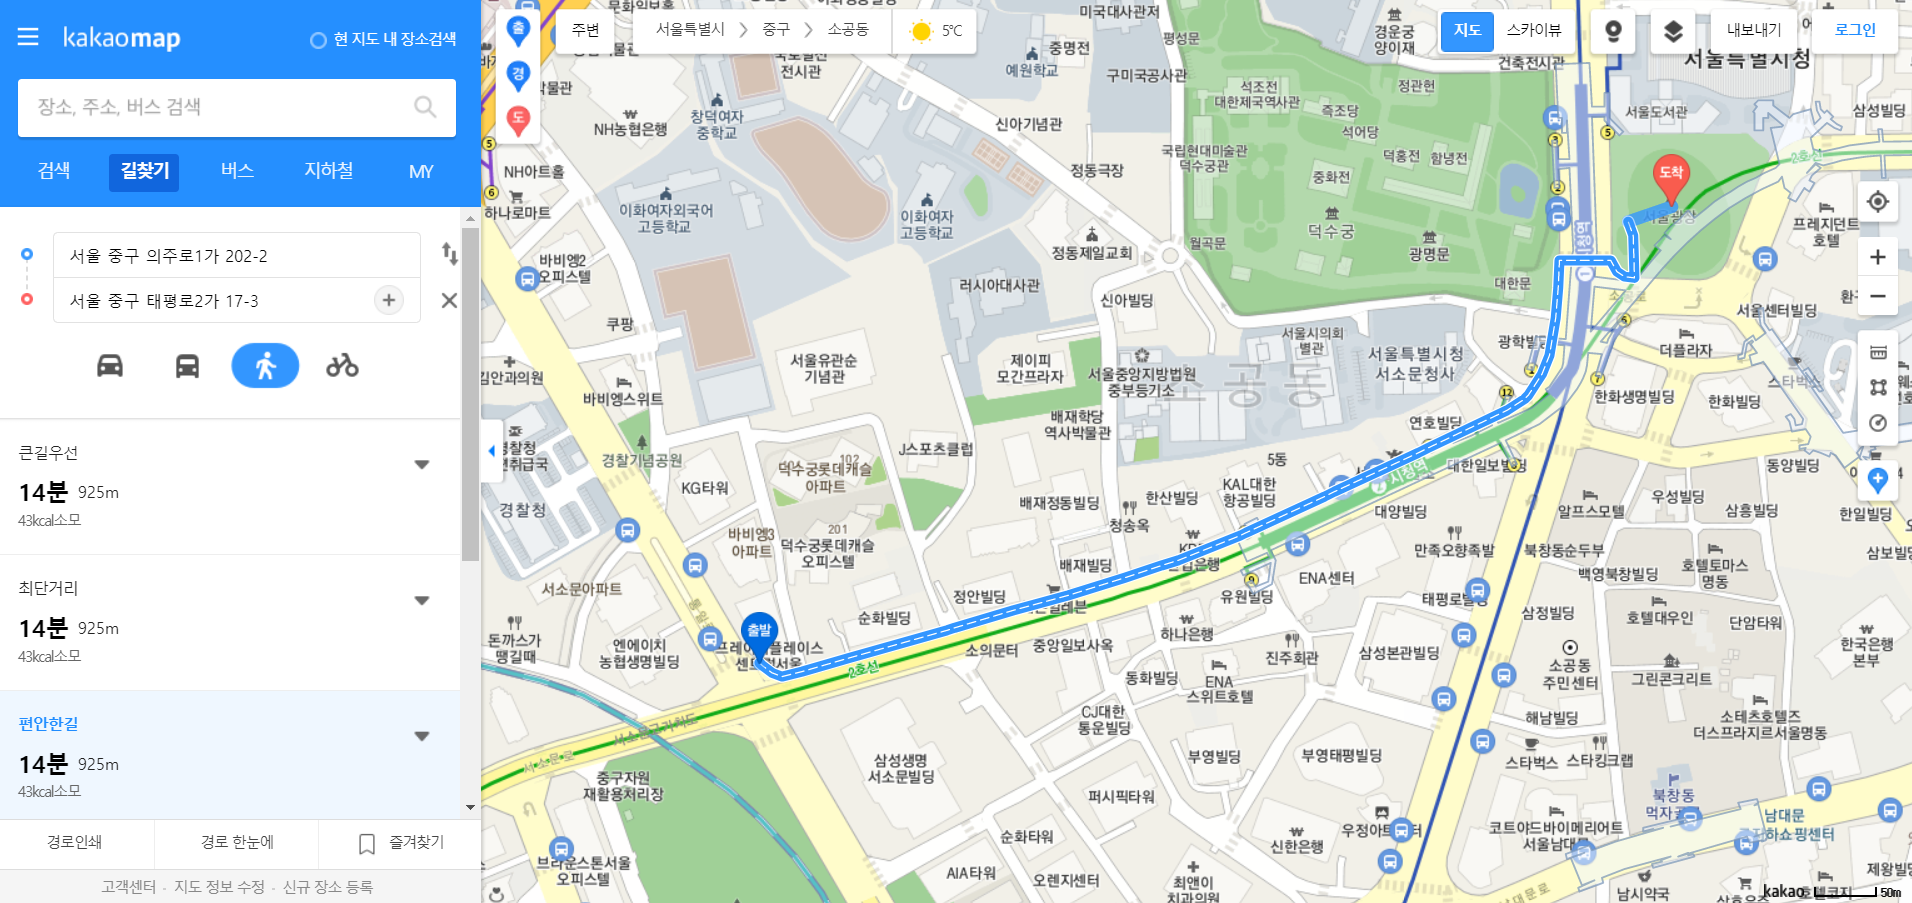

# 수고 많으셨습니다!!!

## OSMNX Example Notebooks
https://github.com/gboeing/osmnx-examples/tree/main/notebooks